Basic methods to interpolate data using scipy

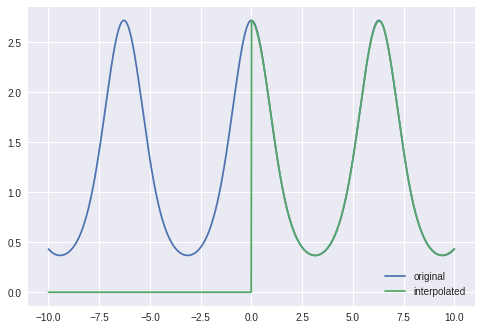

In [84]:
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import math

def y(x):
  return np.exp(np.cos(x))

x_data = np.linspace(0, 10, 15)
y_data = y(x_data)

x_intp = np.linspace(-10, 10, 1000)
# gives out of bounds x's a value of 0
y_fit = interp1d(x_data, y_data, kind="cubic", bounds_error=False, fill_value=0)
y_intp = y_fit(x_intp)

plt.plot(x_intp, y(x_intp))
plt.plot(x_intp, y_intp)

plt.legend(["original", "interpolated"])
plt.show()

Motor class

In [0]:
class Motor:
  '''
  Motor class for a single stage rocket
  Assumes that time=0 is ignition (largely simplifies things)
  '''
  def __init__(self, filepath):
    self.filepath = filepath
    self.motor_data = np.loadtxt(self.filepath, skiprows=2)
    self.time_data = self.motor_data[:,0]
    self.thrust_data = self.motor_data[:,1]
    self.thrust_fit = interp1d(self.time_data, self.thrust_data, kind="linear", bounds_error=False, fill_value=0)
    self.wetMass = None
    self.dryMass = None
    self.burnTime = self.time_data[-1]
 
    with open(self.filepath, 'r') as f:
      first_line = f.readline().split() #actually the second line for the cesaroni's
      self.dryMass = float(first_line[1])
      self.wetMass = float(first_line[2])
      self.massFlowRate = (self.wetMass - self.dryMass) / self.burnTime
      
  def getThrust(self, time):
    return self.thrust_fit(time)
  
  def isPowered(self, time):
    if (time >= self.burnTime) or (time<0):
      return False
    else:
      return True
  
  def getMass(self, time):
    if time < 0:
      return self.wetMass
    elif time > self.burnTime:
      return self.dryMass
    else:
      return self.wetMass - self.massFlowRate * time
  
  def getMassFlow(self, time):
    if time < 0:
      return 0.0
    elif time > self.burnTime:
      return 0.0
    else:
      return self.massFlowRate



Motor thrust interpolation

In [0]:
#from google.colab import files
#uploaded = files.upload()

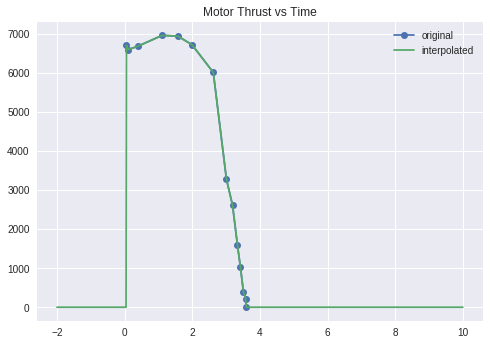

In [87]:
import numpy as np
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt


motor = Motor("Cesaroni_N5800.eng")

x_intp = np.linspace(-2, 10, 1000)

plt.plot(motor.time_data, motor.thrust_data, '-o')
plt.plot(x_intp, motor.thrust_fit(x_intp))
plt.title("Motor Thrust vs Time")
plt.legend(["original", "interpolated"])
plt.show()

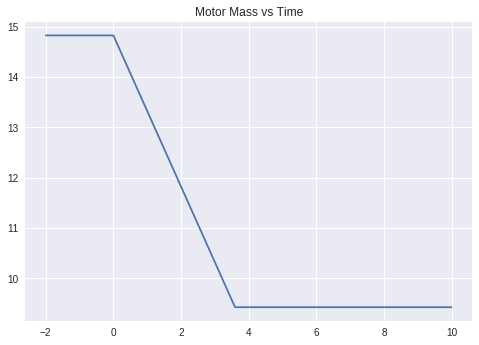

In [88]:
time = np.linspace(-2, 10, 1000)
motorMass = np.zeros(len(time))
for i in range(len(time)):
  motorMass[i] = motor.getMass(time[i])

plt.title("Motor Mass vs Time")
plt.plot(time, motorMass)
plt.show()
  

In [0]:
#@title  { display-mode: "form" }
# This model is valid up to 18km and above the equator and outputs are in metric units
# usage:
# altitude = 0
# atmosphere = Atmosphere(altitude)
# atmosphere.density
# atmosphere.updateAltitude(10000)
# atmosphere.density
class Atmosphere:
  
  sea_pressure = 101.325 * math.pow(10, 3) # Pa
  sea_temperature = 288.15 # K
  lapse_rate = 0.0065 # K/m
  grav_accel = 9.80665 # m/s/s
  gas_constant = 8.31447 # J/mol/K
  molar_mass = 0.0289644 # kg/mol
  # for sutherland
  c1 = 1.458 * math.pow(10, -6)
  s = 110.4
  
  def __init__(self, altitude):
    self.altitude = altitude
    self.density = None
    self.dyn_viscosity = None
    self.kin_viscosity = None
    self.speedOfSound = None
    self.gamma = 1.4
    self.gasConstant = 287 # J/kg/K
    self.temperature = self.sea_temperature
    self.pressure = self.sea_pressure
        
    self.updateAltitude(altitude)
    
  def updateAltitude(self, altitude):
    self.altitude = altitude
    self.temperature = self.__calculateTemperature()
    self.pressure = self.__calculatePressure()
    self.density = self.__calculateDensity()
    self.dyn_viscosity = self.__calculateDynViscosity()
    self.kin_viscosity = self.dyn_viscosity/self.density
    self.speedOfSound = math.sqrt(self.gamma * self.gasConstant * self.temperature)
    
  # https://en.wikipedia.org/wiki/Density_of_air#Altitude 
  def __calculateTemperature(self):
    return self.sea_temperature - (self.lapse_rate * self.altitude)
  
  # https://en.wikipedia.org/wiki/Density_of_air#Altitude  
  def __calculatePressure(self):
    return self.sea_pressure * math.pow(\
        (1 - (self.lapse_rate * self.altitude)/self.sea_temperature),\
        (self.grav_accel * self.molar_mass)/(self.gas_constant * self.lapse_rate)\
    )
  
  # https://en.wikipedia.org/wiki/Density_of_air#Altitude
  def __calculateDensity(self):
    return (self.pressure * self.molar_mass)/(self.gas_constant * self.temperature)
  
  # https://www.cfd-online.com/Wiki/Sutherland%27s_law
  def __calculateDynViscosity(self):
    return (self.c1 * math.pow(self.temperature, 3.0/2.0)) / (self.temperature + self.s)

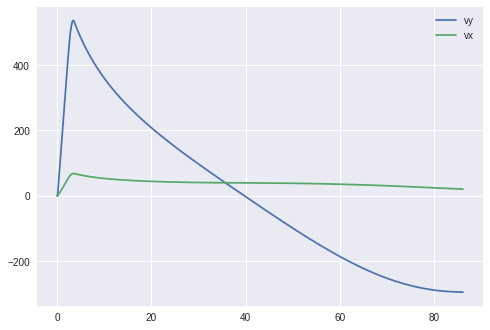

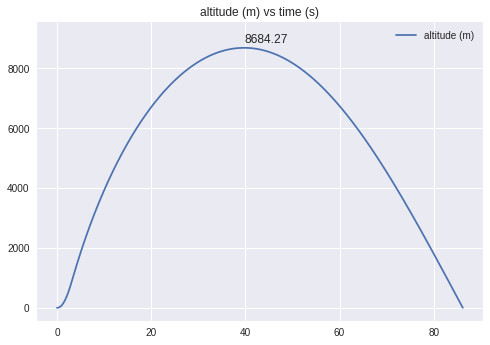

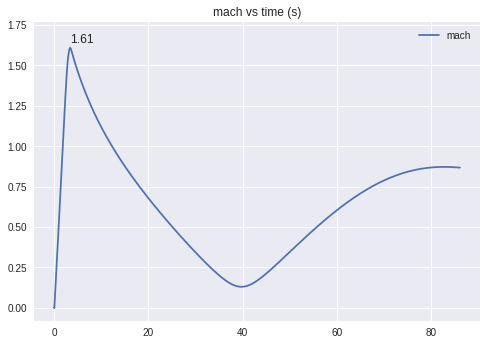

In [95]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy import integrate

'''
constant mass, c_d, gravity
'''
def f(t, z, params):
  x, vx, y, vy = z
  
  motor, atmosphere, area, c_d, mass0, g, theta0, launchrail_length = params
  
  
  # not valid with the equations of motion im using
  mass = mass0 + motor.getMass(t)
  #mass = mass0
  
  # updates the atmospheric properties
  atmosphere.updateAltitude(y)
  density = atmosphere.density
  
  theta = None
  if (y <= launchrail_length):
    theta = theta0
  else:
    theta = math.atan(vy/vx)
    
  V = math.sqrt(vx**2+vy**2)
  machSensor.append(V/atmosphere.speedOfSound)

  drag = (1.0/2.0)*density*(V**2)*area*c_d
  thrust = motor.getThrust(t)
  grav = mass * g
  
  #print("time: {} theta: {} thrust_y: {} drag_y: {} grav: {}".format(t, theta, thrust*np.sin(theta), drag*np.sin(theta), grav))
  #print("time: {} vx: {} vy: {}".format(t, vx, vy))
  #print
  
  derivatives = [
      vx,
      -1.0*(1.0/mass)*drag*np.cos(theta) + (1.0/mass)*thrust*np.cos(theta),
      vy,
      -1.0*(1.0/mass)*drag*np.sin(theta) + (1.0/mass)*thrust*np.sin(theta) - g,
  ]
  
  return derivatives

# event to stop the solver when the ground is hit
def hit_ground(t, y): return y[2]
hit_ground.terminal = True
hit_ground.direction = -1

# additional parameters the solver needs
atmosphere = Atmosphere(0)
area = 0.018 #m**2
c_d = 0.30
mass0 = 20 #kg
g = 9.81 #m/s/s
theta = 84*math.pi/180.0 #rad
launchrail_length = 8.0 #m
params = [motor, atmosphere, area, c_d, mass0, g, theta, launchrail_length]

# Initial conditions
# y_0 is 0.01 instead of 0 so that the hit_ground event works. look into doing it another way
# x, vx, y, vy
z0 = [0., 0., 0.1, 0.]

# https://github.com/scipy/scipy/issues/8352#issuecomment-362918089
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html#scipy.integrate.solve_ivp
# http://epirecip.es/epicookbook/chapters/sir/python
# Call the ODE solver
# Make time array for solution
#tStop = 80.
#tInc = 0.01
#t_range = np.arange(0., tStop, tInc)

psoln = integrate.solve_ivp(fun=lambda t, y: f(t, y, params), t_span=[0., 100], y0=z0, events=hit_ground, max_step=0.1)

vx = psoln["y"][1]
y = psoln["y"][2]
vy = psoln["y"][3]
t = psoln["t"]

plt.plot(t, vy, label="vy")
plt.plot(t, vx, label="vx")
plt.legend()
plt.show()

# change so it returns a plot instead
def plotCurvesWithMax(x, y, labelStr, title):
  plt.plot(x, y, label=labelStr)
  plt.title(title)
  
  apogee_y = np.max(y)
  apogee_x= x[np.argmax(y)]
  
  plt.text(apogee_x, apogee_y+(0.02*apogee_y), "({:.2f}".format(apogee_y))
  x1,x2,y1,y2 = plt.axis()
  plt.axis((x1,x2,y1,y2 + (0.05*apogee_y)))
  plt.legend()
  plt.show()

plotCurvesWithMax(t, y, "altitude (m)", "altitude (m) vs time (s)")

machNumbers = np.zeros(len(t))
for i in range(len(t)):
  atmosphere.updateAltitude(y[i])
  machNumbers[i] = math.sqrt(vx[i]**2 + vy[i]**2) / atmosphere.speedOfSound

plotCurvesWithMax(t, machNumbers, "mach", "mach vs time (s)")


In [0]:
# might need to update scipy
# !apt install --upgrade scipy
# then click on runtime>restart runtime...